<a href="https://colab.research.google.com/github/hemptastic-2020/AIML/blob/master/ML_LAB_4_SPANDAN_PAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd   
import numpy as np    
import matplotlib.pyplot as plt 
%matplotlib inline
%config InlineBackend.figure_formats = ['retina']
import seaborn as sns
import time
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import KFold, cross_val_score, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss
from sklearn.metrics import auc, roc_curve, roc_auc_score, precision_recall_curve
from sklearn.metrics import fbeta_score, cohen_kappa_score
SEED = 42

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving pima-indians-diabetes.csv to pima-indians-diabetes (2).csv


In [ ]:
df = pd.read_csv('pima-indians-diabetes.csv')
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [ ]:
# data overview
print ('Rows     : ', df.shape[0])
print ('Columns  : ', df.shape[1])
print ('\nFeatures : \n', df.columns.tolist())
print ('\nMissing values :  ', df.isnull().sum().values.sum())
print ('\nUnique values :  \n', df.nunique())

Rows     :  768
Columns  :  9

Features : 
 ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']

Missing values :   0

Unique values :  
 Pregnancies                  17
Glucose                     136
BloodPressure                47
SkinThickness                51
Insulin                     186
BMI                         248
DiabetesPedigreeFunction    517
Age                          52
Outcome                       2
dtype: int64


In [ ]:
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

0    500
1    268
Name: Outcome, dtype: int64


Text(0.5, 1.0, 'Diabetes Outcome')

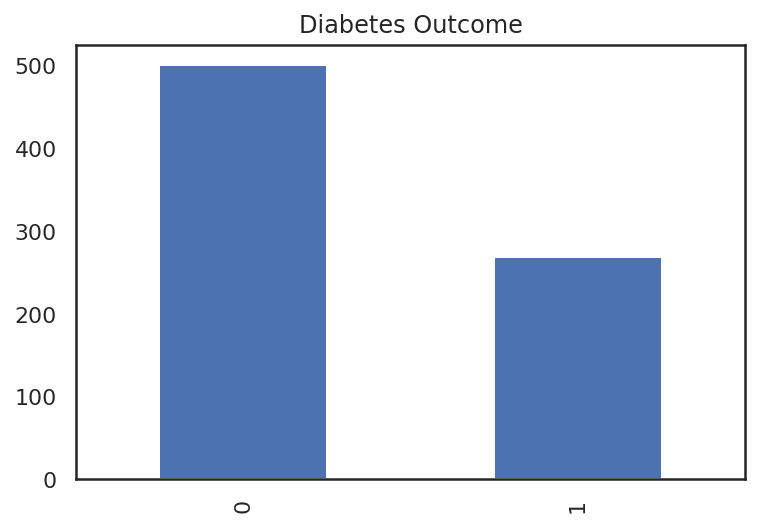

In [ ]:
# '0'= no diabetes; '1'= diabetes
print(df.Outcome.value_counts())
df['Outcome'].value_counts().plot(kind='bar').set_title('Diabetes Outcome')

In [ ]:
df.Outcome.value_counts()[1] / df.Outcome.count()

0.3489583333333333

In [ ]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


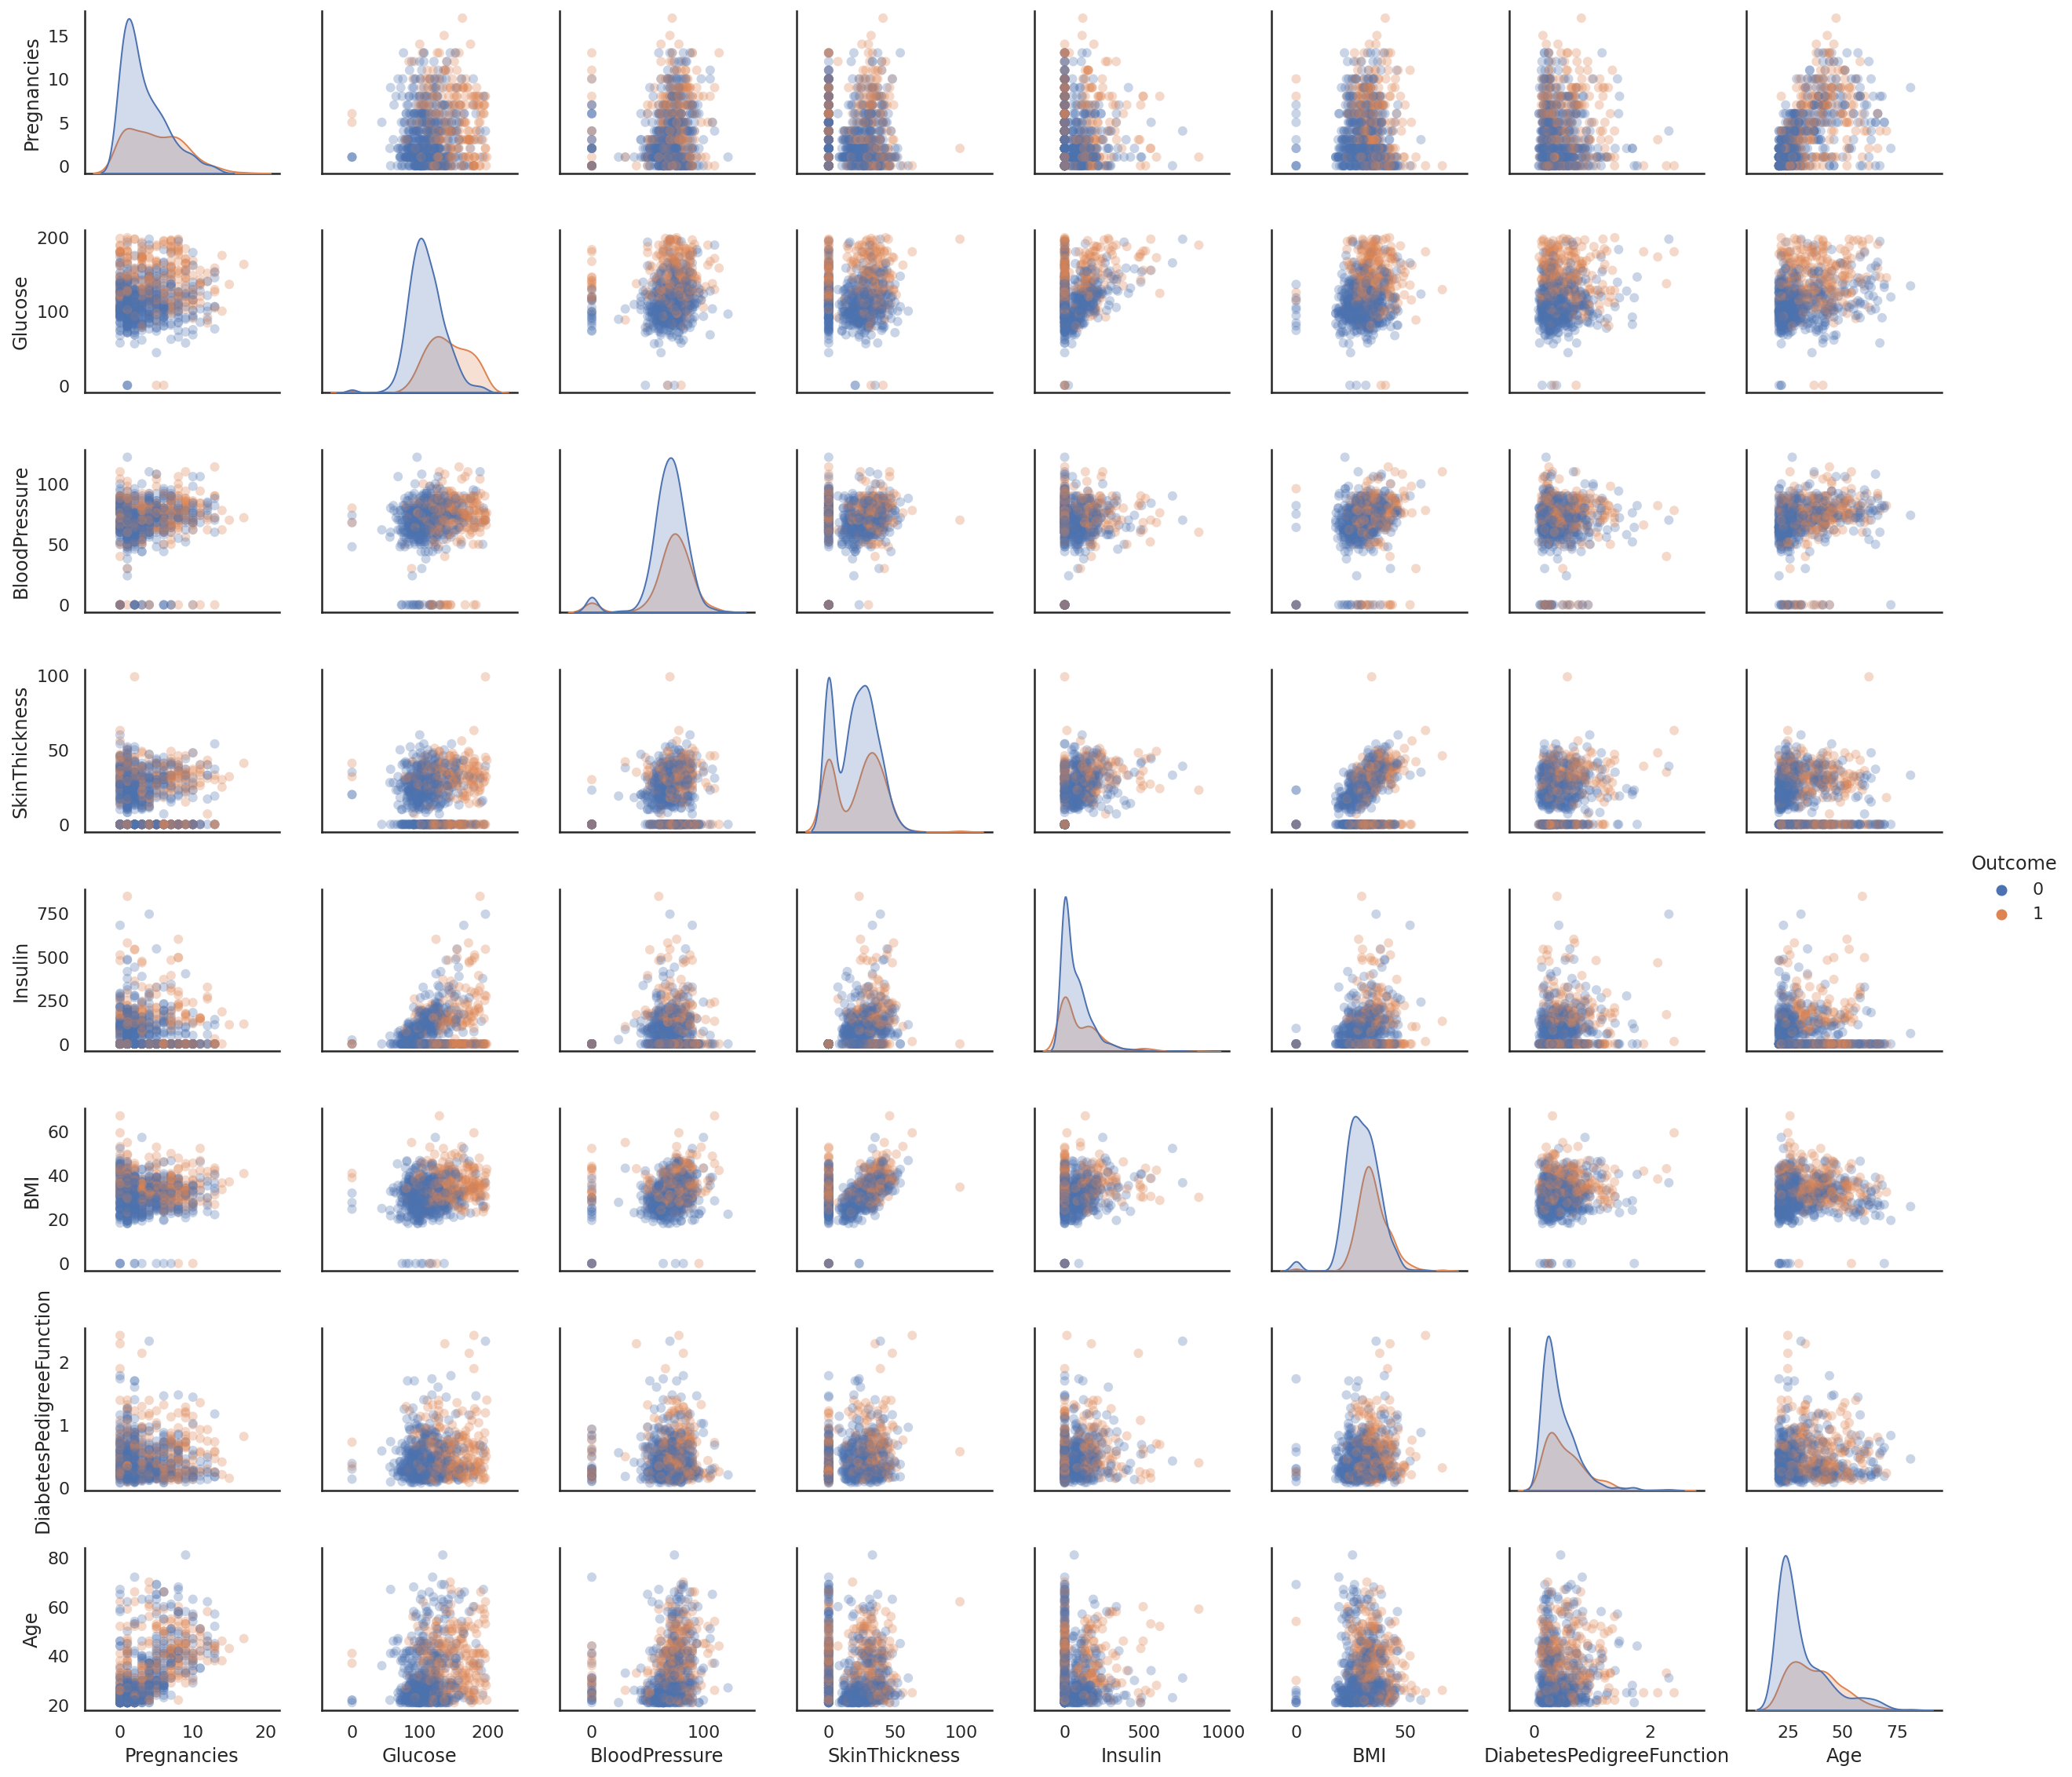

In [ ]:
sns.pairplot(df, hue='Outcome', plot_kws=dict(alpha=.3, edgecolor='none'), height=2, aspect=1.1)

(9.5, -0.5)

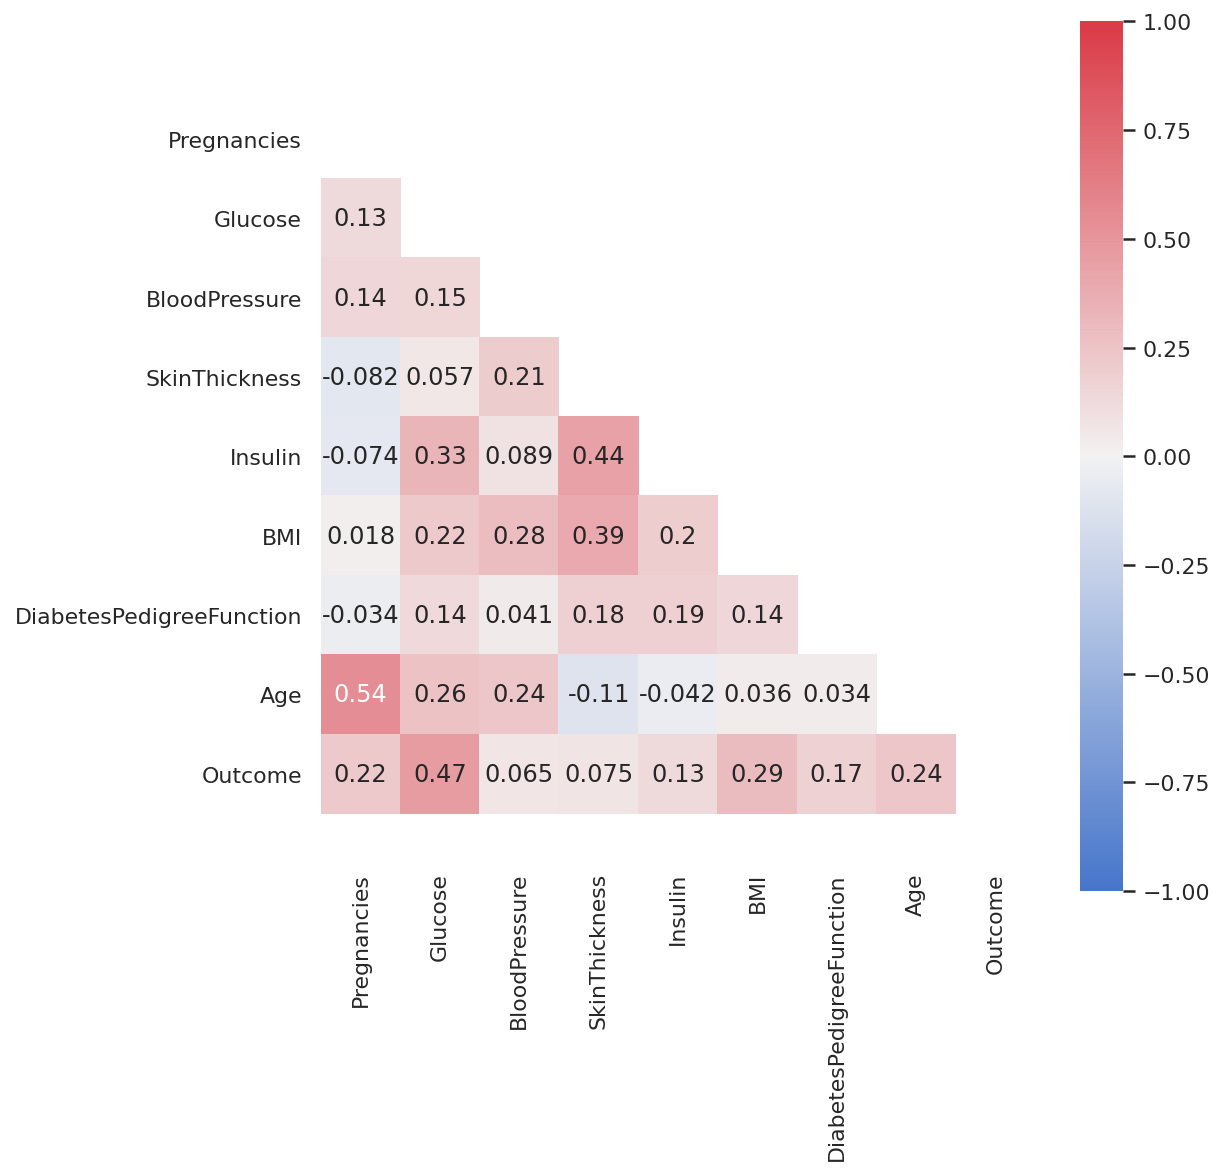

In [ ]:
sns.set(style="white")
mask = np.zeros_like(df.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
fig, ax = plt.subplots(figsize=(8,8))
cmap = sns.diverging_palette(255, 10, as_cmap=True)  
sns.heatmap(df.corr(), mask=mask, annot=True, square=True, cmap=cmap , vmin=-1, vmax=1, ax=ax) 
bottom, top = ax.get_ylim()
ax.set_ylim(bottom+0.5, top-0.5)

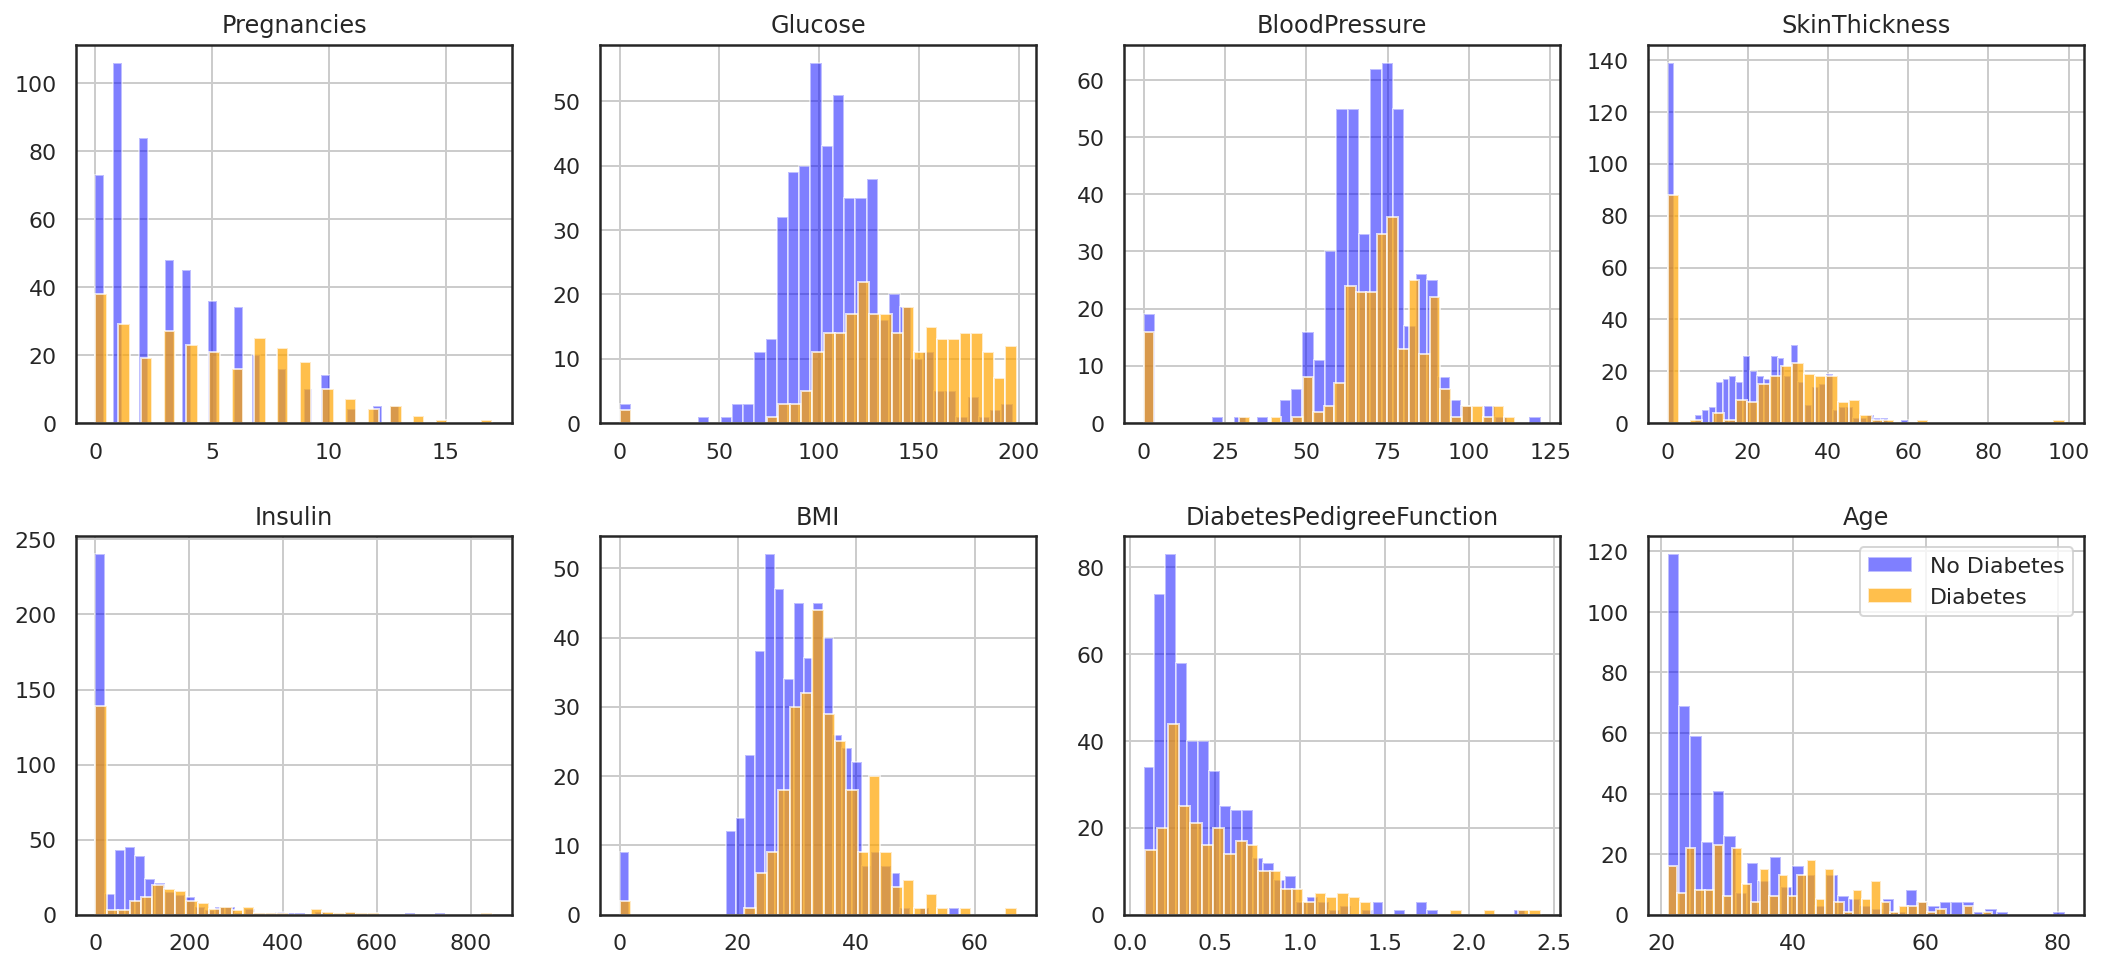

In [ ]:
features = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']

ROWS, COLS = 2, 4
fig, ax = plt.subplots(ROWS, COLS, figsize=(18,8) )
row, col = 0, 0
for i, feature in enumerate(features):
    if col == COLS - 1:
        row += 1
    col = i % COLS
    
    df[df.Outcome==0][feature].hist(bins=35, color='blue', alpha=0.5, ax=ax[row, col]).set_title(feature)
    df[df.Outcome==1][feature].hist(bins=35, color='orange', alpha=0.7, ax=ax[row, col])
    
plt.legend(['No Diabetes', 'Diabetes'])
fig.subplots_adjust(hspace=0.3)

In [ ]:
# there are zero values in Glucose, BloodPressure, SkinThickness, Insulin, BMI
# need to replace zero by median, 2 steps: replace 0 by NaN, then replace NaN by median (so that 0 will not affect median)
# after this step, run previous visualisation again

df.Glucose.replace(0, np.nan, inplace=True)
df.Glucose.replace(np.nan, df['Glucose'].median(), inplace=True)
df.BloodPressure.replace(0, np.nan, inplace=True)
df.BloodPressure.replace(np.nan, df['BloodPressure'].median(), inplace=True)
df.SkinThickness.replace(0, np.nan, inplace=True)
df.SkinThickness.replace(np.nan, df['SkinThickness'].median(), inplace=True)
df.Insulin.replace(0, np.nan, inplace=True)
df.Insulin.replace(np.nan, df['Insulin'].median(), inplace=True)
df.BMI.replace(0, np.nan, inplace=True)
df.BMI.replace(np.nan, df['BMI'].median(), inplace=True)

In [ ]:
X, y = df.drop('Outcome', axis=1), df['Outcome']
print(X.shape, y.shape)

(768, 8) (768,)


Use LassoCV to find the optimal ALPHA value for L1 regularization
X_scaled (768, 8)
LASSO best alpha:  0.008603464416684501
[('Glucose', 0.1880413802244648), ('BMI', 0.08931918266428746), ('Pregnancies', 0.06311584122142201), ('DiabetesPedigreeFunction', 0.036276542515315036), ('Age', 0.016956407714825757), ('BloodPressure', -0.0), ('SkinThickness', 0.0), ('Insulin', -0.0)]


Text(0.5, 1.0, 'Top Features derived by LassoCV')

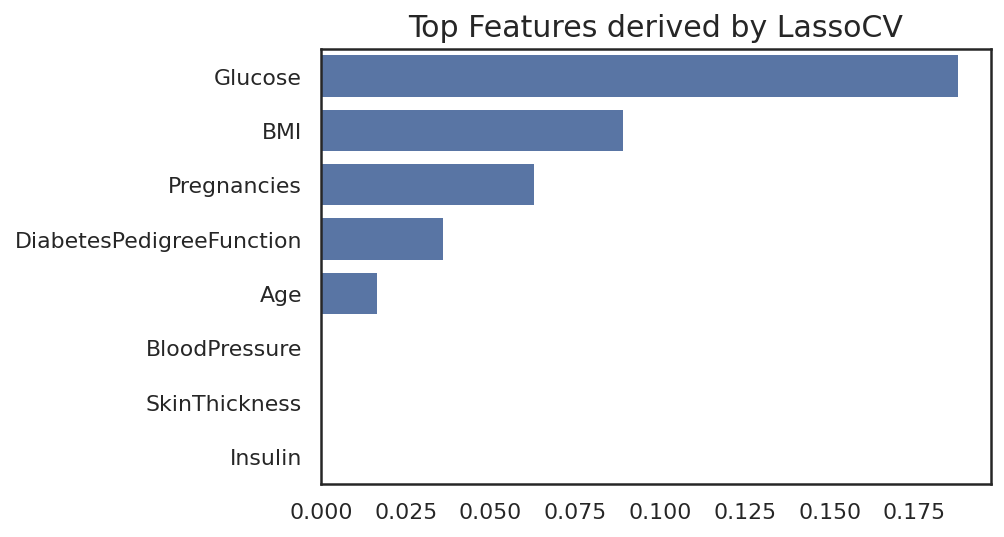

In [ ]:
from sklearn.linear_model import LassoCV, RidgeCV, ElasticNetCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

print('Use LassoCV to find the optimal ALPHA value for L1 regularization')

std = StandardScaler()
std.fit(X.values)
X_scaled = std.transform(X.values)
print('X_scaled', X_scaled.shape)

alphavec = 10**np.linspace(-3,3,200)   # alpha varies from 0.001 to 1000
lasso_model = LassoCV(alphas = alphavec, cv=5)
lasso_model.fit(X_scaled, y)

print('LASSO best alpha: ', lasso_model.alpha_ )

zipped = list(zip(X.columns, lasso_model.coef_)) 
zipped = sorted(zipped, key=lambda x: x[1], reverse=True)
print(zipped)
a,b = zip(*zipped)
sns.barplot(y=list(a), x=list(b), color='b')
plt.title('Top Features derived by LassoCV', size=15)

In [ ]:
import statsmodels.api as sm
X = sm.add_constant(X)  
model = sm.OLS(y, X)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Outcome   R-squared:                       0.321
Model:                            OLS   Adj. R-squared:                  0.314
Method:                 Least Squares   F-statistic:                     44.90
Date:                Sat, 12 Dec 2020   Prob (F-statistic):           4.25e-59
Time:                        21:26:55   Log-Likelihood:                -371.86
No. Observations:                 768   AIC:                             761.7
Df Residuals:                     759   BIC:                             803.5
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -1.0237      0.104     -9.841      0.000      -1.228      -0.819
Pregnancies                  0.0206      0.005      4.074      0.000       0.011       0.031
Glucose                      0.0065      0.001     11.967      0.000       0.005       0.008
BloodPressure               -0.0012      0.001     -0.924      0.356      -0.004       0.001
SkinThickness                0.0002      0.002      0.098      0.922      -0.004       0.004
Insulin                     -0.0002      0.000     -0.850      0.396      -0.001       0.000
BMI                          0.0145      0.003      5.574      0.000       0.009       0.020
DiabetesPedigreeFunction     0.1306      0.044      2.963      0.003       0.044       0.217
Age                          0.0021      0.002      1.355      0.176      -0.001       0.005
==============================================================================
Omnibus:                       33.680   Durbin-Watson:                   1.961
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               23.901
Skew:                           0.322   Prob(JB):                     6.46e-06
Kurtosis:                       2.424   Cond. No.                     1.60e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.6e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
X = df.drop('Outcome', axis=1)   
y = df['Outcome']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=SEED, stratify=y)
print('X_train', X_train.shape)
print('y_train', y_train.shape)
print('X_test', X_test.shape)
print('y_test', y_test.shape)



X_train (614, 8)
y_train (614,)
X_test (154, 8)
y_test (154,)


In [ ]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

def baseline_report(model, X_train, X_test, y_train, y_test, name):
    model.fit(X_train, y_train)
    accuracy     = np.mean(cross_val_score(model, X_train, y_train, cv=kf, scoring='accuracy'))
    precision    = np.mean(cross_val_score(model, X_train, y_train, cv=kf, scoring='precision'))
    recall       = np.mean(cross_val_score(model, X_train, y_train, cv=kf, scoring='recall'))
    f1score      = np.mean(cross_val_score(model, X_train, y_train, cv=kf, scoring='f1'))
    rocauc       = np.mean(cross_val_score(model, X_train, y_train, cv=kf, scoring='roc_auc'))
    y_pred = model.predict(X_test)
    logloss      = log_loss(y_test, y_pred)   
    df_model = pd.DataFrame({'model'        : [name],
                             'accuracy'     : [accuracy],
                             'precision'    : [precision],
                             'recall'       : [recall],
                             'f1score'      : [f1score],
                             'rocauc'       : [rocauc],
                             'logloss'      : [logloss],
                             'timetaken'    : [0]       })  
    return df_model

# to evaluate baseline models
gnb = GaussianNB()
mnb = MultinomialNB()
knn = KNeighborsClassifier()
decisiontree = DecisionTreeClassifier()
svc = SVC()

# to concat all models
df_models = pd.concat([baseline_report(gnb, X_train, X_test, y_train, y_test, 'GaussianNB'),
                       baseline_report(mnb, X_train, X_test, y_train, y_test, 'MultinomialNB'),
                       baseline_report(knn, X_train, X_test, y_train, y_test, 'KNN'),
                       baseline_report(decisiontree, X_train, X_test, y_train, y_test, 'DecisionTree'),
                       baseline_report(svc, X_train, X_test, y_train, y_test, 'SVC'),
                       ], axis=0).reset_index()
df_models = df_models.drop('index', axis=1)
df_models

,model,accuracy,precision,recall,f1score,rocauc,logloss,timetaken
0,GaussianNB,0.762268,0.685894,0.598450,0.636877,0.827955,10.316912,0
1,MultinomialNB,0.640144,0.480193,0.397674,0.432912,0.641613,13.008220,0
2,KNN,0.740997,0.643081,0.579402,0.608615,0.779509,11.214008,0
3,DecisionTree,0.669359,0.512696,0.532337,0.528737,0.632402,10.989715,0
4,SVC,0.767106,0.755688,0.495460,0.597166,0.824277,9.644012,0


In [ ]:
def model_report(model, X_train, X_test, y_train, y_test, model_name):
    print('\nSearch for OPTIMAL THRESHOLD, vary from 0.0001 to 0.9999, fit/predict on train/test data')
    model.fit(X_train, y_train)
    optimal_th = 0.5   # start with default threshold value
    
    for i in range(0,3):
        score_list = []
        print('\nLooping decimal place', i+1) 
        th_list = [np.linspace(optimal_th-0.4999, optimal_th+0.4999, 11), 
                  # eg [ 0.0001 , 0.1008, 0.2006, 0.3004, 0.4002, 0.5, 0.5998, 0.6996, 0.7994, 0.8992, 0.9999 ]
                 np.linspace(optimal_th-0.1, optimal_th+0.1, 21), 
                  # eg 0.3xx [ 0.2 , 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 ]
                 np.linspace(optimal_th-0.01, optimal_th+0.01, 21)]
                  # eg 0.30x [ 0.29 , 0.291, 0.292, 0.293, 0.294, 0.295, 0.296, 0.297, 0.298, 0.299, 0.3  , 0.301, 0.302, 0.303, 0.304, 0.305, 0.306, 0.307, 0.308, 0.309, 0.31 ]
        for th in th_list[i]:
            if th<0: 
                score_list.append(-1)
                continue
            y_pred = (model.predict_proba(X_test)[:,1] >= th)
            f1scor = f1_score(y_test, y_pred)
            score_list.append(f1scor)
            print('{:.3f}->{:.4f}'.format(th, f1scor), end=',  ')   # display f1score in 4 decimal pl
        optimal_th = float(th_list[i][score_list.index(max(score_list))])

    print('optimal F1 score = {:.4f}'.format(max(score_list)))
    print('optimal threshold = {:.3f}'.format(optimal_th))

    print(model_name, 'accuracy score is')
    print('Training: {:.2f}%'.format(100*model.score(X_train, y_train)))  # score uses accuracy
    accuracy      = model.score(X_test, y_test)
    print('Test set: {:.2f}%'.format(100*accuracy))

    y_pred = (model.predict_proba(X_test)[:,1] >= 0.25)
    print('\nAdjust threshold to 0.25:')
    print('Precision: {:.4f},   Recall: {:.4f},   F1 Score: {:.4f}'.format(
        precision_score(y_test, y_pred), recall_score(y_test, y_pred), f1_score(y_test, y_pred)))
    print(model_name, 'confusion matrix: \n', confusion_matrix(y_test, y_pred))

    y_pred = model.predict(X_test)
    print('\nDefault threshold of 0.50:')
    print('Precision: {:.4f},   Recall: {:.4f},   F1 Score: {:.4f}'.format(
        precision_score(y_test, y_pred), recall_score(y_test, y_pred), f1_score(y_test, y_pred)))
    print(model_name, 'confusion matrix: \n', confusion_matrix(y_test, y_pred))

    y_pred = (model.predict_proba(X_test)[:,1] >= 0.75)
    print('\nAdjust threshold to 0.75:')
    print('Precision: {:.4f},   Recall: {:.4f},   F1 Score: {:.4f}'.format(
        precision_score(y_test, y_pred), recall_score(y_test, y_pred), f1_score(y_test, y_pred)))
    print(model_name, 'confusion matrix: \n', confusion_matrix(y_test, y_pred))

    y_pred = (model.predict_proba(X_test)[:,1] >= optimal_th)
#     y_pred = [1 if x==True else 0 if x==False else x for x in y_pred]   # .predict->0/1; .predict_proba->False/True
    print('\nOptimal threshold {:.3f}'.format(optimal_th))
    precision    = precision_score(y_test, y_pred)
    recall       = recall_score(y_test, y_pred)
    f1score      = f1_score(y_test, y_pred)
    print('Precision: {:.4f},   Recall: {:.4f},   F1 Score: {:.4f}'.format(precision, recall, f1score))
    print(model_name, 'confusion matrix: \n', confusion_matrix(y_test, y_pred))
    
    y_pred = model.predict_proba(X_test)[:,1]   # use this at optimal th, for AUC and logloss
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    rocauc       = auc(fpr, tpr)
    print(model_name, 'AUC: {:.4f}'.format(rocauc))
    logloss      = log_loss(y_test, y_pred)   # same result using y_pred = model.predict_proba(X_test)
    print(model_name, 'Log-loss: {:.4f}'.format(logloss))

    df_model = pd.DataFrame({'model'        : [model_name],
                             'accuracy'     : [accuracy],
                             'precision'    : [precision],
                             'recall'       : [recall],
                             'f1score'      : [f1score],
                             'rocauc'       : [rocauc],
                             'logloss'      : [logloss],
                             'timetaken'    : [1000]       })   # timetaken for comparison later
    return df_model

In [ ]:
print('\n"""""" GaussianNB """"""')
time1 = time.time()
gnb = GaussianNB()
model1 = model_report(gnb, X_train, X_test, y_train, y_test, 'GaussianNB')
model1.timetaken[0] = time.time() - time1

print('\n"""""" MultinomialNB """"""')
time1 = time.time()
mnb = MultinomialNB()
model2 = model_report(mnb, X_train, X_test, y_train, y_test, 'MultinomialNB')
model2.timetaken[0] = time.time() - time1


"""""" GaussianNB """"""

Search for OPTIMAL THRESHOLD, vary from 0.0001 to 0.9999, fit/predict on train/test data

Looping decimal place 1
0.000->0.5192,  0.100->0.6259,  0.200->0.6260,  0.300->0.5882,  0.400->0.5812,  0.500->0.5965,  0.600->0.5926,  0.700->0.5686,  0.800->0.5000,  0.900->0.4524,  1.000->0.1333,  
Looping decimal place 2
0.100->0.6259,  0.110->0.5972,  0.120->0.6014,  0.130->0.6056,  0.140->0.6143,  0.150->0.6143,  0.160->0.6087,  0.170->0.6269,  0.180->0.6316,  0.190->0.6260,  0.200->0.6260,  0.210->0.6308,  0.220->0.6357,  0.230->0.6349,  0.240->0.6240,  0.250->0.6240,  0.260->0.6129,  0.270->0.6066,  0.280->0.5833,  0.290->0.5833,  0.300->0.5882,  
Looping decimal place 3
0.210->0.6308,  0.211->0.6308,  0.212->0.6308,  0.213->0.6308,  0.214->0.6308,  0.215->0.6308,  0.216->0.6308,  0.217->0.6308,  0.218->0.6308,  0.219->0.6308,  0.220->0.6357,  0.221->0.6357,  0.222->0.6357,  0.223->0.6299,  0.224->0.6299,  0.225->0.6349,  0.226->0.6349,  0.227->0.6349,  0.228->0.

In [ ]:
print('\n"""""" KNN """""" ')
time1 = time.time()
print('\nSearch for optimal hyperparameter K in KNN, vary K from 1 to 20, using KFold(5) Cross Validation on train data')
kf = KFold(n_splits=5, random_state=SEED, shuffle=True)  #produce the k folds
k_scores = []
for k in range(1, 21):
    knn = KNeighborsClassifier(n_neighbors = k)
    cvs = cross_val_score(knn, X_train, y_train, cv=kf, scoring='f1').mean()
    k_scores.append(cvs)
    print('{:.4f}'.format(cvs), end=", ")
print('optimal cv F1 score = {:.4f}'.format(max(k_scores)))   # 4 decimal pl
optimal_k = k_scores.index(max(k_scores))+1   # index 0 is for k=1
print('optimal value of K =', optimal_k)

knn = KNeighborsClassifier(n_neighbors = optimal_k)
model3 = model_report(knn, X_train, X_test, y_train, y_test, 'KNN')
model3.timetaken[0] = time.time() - time1

print('\nCompare with KNN classification_report (same as default threshold 0.50)')
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print(metrics.classification_report(y_test, y_pred))


"""""" KNN """""" 

Search for optimal hyperparameter K in KNN, vary K from 1 to 20, using KFold(5) Cross Validation on train data
0.5102, 0.4482, 0.5753, 0.5375, 0.5634, 0.5449, 0.5951, 0.5347, 0.5926, 0.5528, 0.6016, 0.5543, 0.5804, 0.5669, 0.5830, 0.5699, 0.5892, 0.5605, 0.5970, 0.5683, optimal cv F1 score = 0.6016
optimal value of K = 11

Search for OPTIMAL THRESHOLD, vary from 0.0001 to 0.9999, fit/predict on train/test data

Looping decimal place 1
0.000->0.5746,  0.100->0.6012,  0.200->0.6174,  0.300->0.5873,  0.400->0.5345,  0.500->0.5143,  0.600->0.4773,  0.700->0.4198,  0.800->0.3333,  0.900->0.2258,  1.000->0.0364,  
Looping decimal place 2
0.100->0.6012,  0.110->0.6012,  0.120->0.6012,  0.130->0.6012,  0.140->0.6012,  0.150->0.6012,  0.160->0.6012,  0.170->0.6012,  0.180->0.6012,  0.190->0.6174,  0.200->0.6174,  0.210->0.6174,  0.220->0.6174,  0.230->0.6174,  0.240->0.6174,  0.250->0.6174,  0.260->0.6174,  0.270->0.6174,  0.280->0.5873,  0.290->0.5873,  0.300->0.5873,  
Lo

In [ ]:
print('\n"""""" DecisionTreeClassifier """"""')
time1 = time.time()
print('\nSearch for optimal max_depth in DecisionTree, vary 2 to 10, using KFold(5) Cross Validation on train data')
kf = KFold(n_splits=5, random_state=SEED, shuffle=True)  #produce the k folds
d_scores = []
for d in range(2, 11):
    decisiontree = DecisionTreeClassifier(max_depth=d)
    cvs = cross_val_score(decisiontree, X_train, y_train, cv=kf, scoring='f1').mean()
    d_scores.append(cvs)
    print('{:.4f}'.format(cvs), end=", ")
print('optimal F1 score = {:.4f}'.format(max(d_scores)))   # 4 decimal pl
optimal_d = d_scores.index(max(d_scores))+2   # index 0 is for d=2
print('optimal max_depth =', optimal_d)

decisiontree = DecisionTreeClassifier(max_depth=optimal_d)
model4 = model_report(decisiontree, X_train, X_test, y_train, y_test, 'DecisionTree')
model4.timetaken[0] = time.time() - time1
# Note: results keep changing in each run


"""""" DecisionTreeClassifier """"""

Search for optimal max_depth in DecisionTree, vary 2 to 10, using KFold(5) Cross Validation on train data
0.5065, 0.5032, 0.6382, 0.6142, 0.6178, 0.6319, 0.6058, 0.5915, 0.5777, optimal F1 score = 0.6382
optimal max_depth = 4

Search for OPTIMAL THRESHOLD, vary from 0.0001 to 0.9999, fit/predict on train/test data

Looping decimal place 1
0.000->0.5121,  0.100->0.5814,  0.200->0.6716,  0.300->0.6891,  0.400->0.6838,  0.500->0.6916,  0.600->0.3514,  0.700->0.3514,  0.800->0.3514,  0.900->0.0000,  1.000->0.0000,  
Looping decimal place 2
0.400->0.6838,  0.410->0.6838,  0.420->0.6838,  0.430->0.6838,  0.440->0.6838,  0.450->0.6838,  0.460->0.6916,  0.470->0.6916,  0.480->0.6916,  0.490->0.6916,  0.500->0.6916,  0.510->0.6916,  0.520->0.6916,  0.530->0.6916,  0.540->0.6916,  0.550->0.6916,  0.560->0.3514,  0.570->0.3514,  0.580->0.3514,  0.590->0.3514,  0.600->0.3514,  
Looping decimal place 3
0.450->0.6838,  0.451->0.6916,  0.452->0.6916,  0.453->0.6

In [ ]:
print('\n"""""" SVC """"""')
time1 = time.time()
svc = SVC(gamma='scale', probability=True)
model5 = model_report(svc, X_train, X_test, y_train, y_test, 'SVC')
model5.timetaken[0] = time.time() - time1


"""""" SVC """"""

Search for OPTIMAL THRESHOLD, vary from 0.0001 to 0.9999, fit/predict on train/test data

Looping decimal place 1
0.000->0.5192,  0.100->0.5761,  0.200->0.6525,  0.300->0.6000,  0.400->0.5607,  0.500->0.5361,  0.600->0.4828,  0.700->0.4051,  0.800->0.2817,  0.900->0.1905,  1.000->0.0000,  
Looping decimal place 2
0.100->0.5761,  0.110->0.5989,  0.120->0.6127,  0.130->0.6347,  0.140->0.6341,  0.150->0.6538,  0.160->0.6755,  0.170->0.6757,  0.180->0.6757,  0.190->0.6575,  0.200->0.6525,  0.210->0.6667,  0.220->0.6618,  0.230->0.6418,  0.240->0.6418,  0.250->0.6412,  0.260->0.6142,  0.270->0.6080,  0.280->0.6129,  0.290->0.5950,  0.300->0.6000,  
Looping decimal place 3
0.160->0.6755,  0.161->0.6755,  0.162->0.6755,  0.163->0.6755,  0.164->0.6800,  0.165->0.6800,  0.166->0.6800,  0.167->0.6800,  0.168->0.6711,  0.169->0.6757,  0.170->0.6757,  0.171->0.6757,  0.172->0.6757,  0.173->0.6757,  0.174->0.6757,  0.175->0.6757,  0.176->0.6757,  0.177->0.6757,  0.178->0.6757,  

In [ ]:
# concat all models
df_models_tuned = pd.concat([model1,model2,model3,model4,model5],axis = 0).reset_index()
df_models_tuned.drop('index', axis=1, inplace=True)
df_models_tuned

,model,accuracy,precision,recall,f1score,rocauc,logloss,timetaken
0,GaussianNB,0.701299,0.546667,0.759259,0.635659,0.764630,0.944044,0
1,MultinomialNB,0.623377,0.430000,0.796296,0.558442,0.614630,2.251321,0
2,KNN,0.668831,0.484211,0.851852,0.617450,0.732500,0.992776,1
3,DecisionTree,0.785714,0.698113,0.685185,0.691589,0.788704,0.761588,0
4,SVC,0.720779,0.531250,0.944444,0.680000,0.781019,0.566325,0


In [ ]:
df_models   # compare with baseline results before tuning

,model,accuracy,precision,recall,f1score,rocauc,logloss,timetaken
0,GaussianNB,0.762268,0.685894,0.598450,0.636877,0.827955,10.316912,0
1,MultinomialNB,0.640144,0.480193,0.397674,0.432912,0.641613,13.008220,0
2,KNN,0.740997,0.643081,0.579402,0.608615,0.779509,11.214008,0
3,DecisionTree,0.669359,0.512696,0.532337,0.528737,0.632402,10.989715,0
4,SVC,0.767106,0.755688,0.495460,0.597166,0.824277,9.644012,0


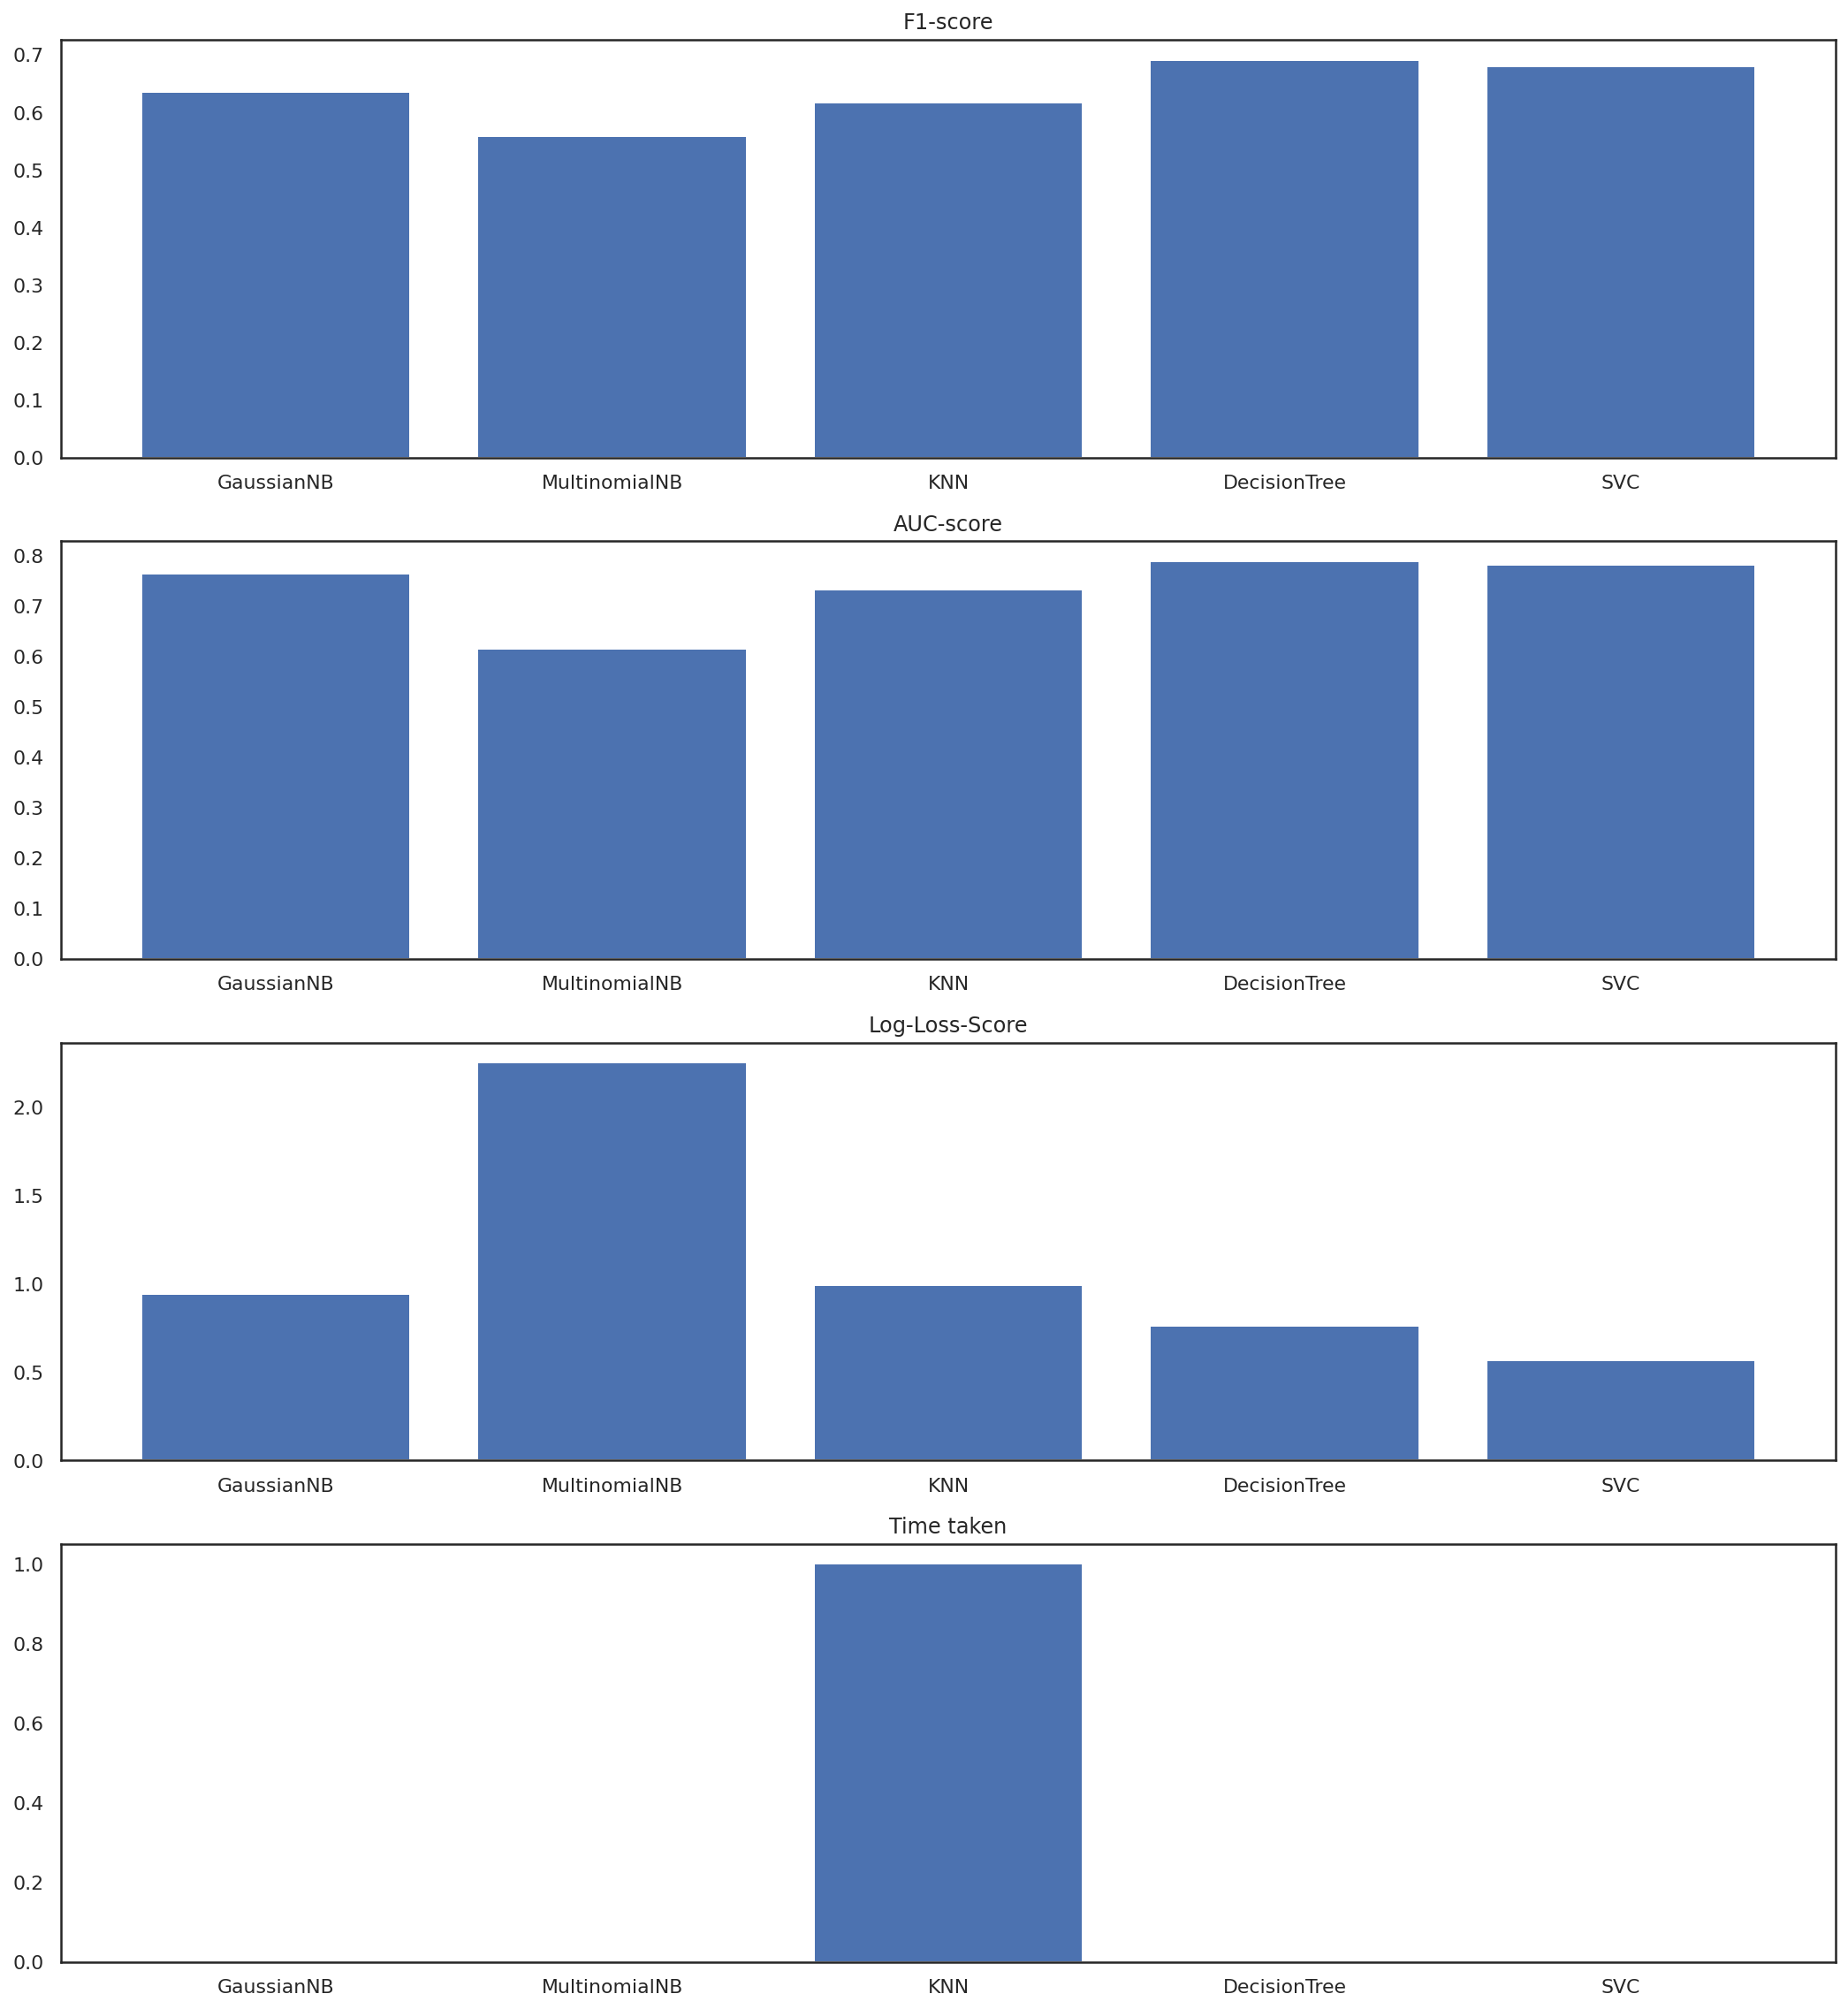

In [ ]:
fig, ax = plt.subplots(4, 1, figsize=(18, 20))

ax[0].bar(df_models_tuned.model, df_models_tuned.f1score)
ax[0].set_title('F1-score')

ax[1].bar(df_models_tuned.model, df_models_tuned.rocauc)
ax[1].set_title('AUC-score')

ax[2].bar(df_models_tuned.model, df_models_tuned.logloss)
ax[2].set_title('Log-Loss-Score')

ax[3].bar(df_models_tuned.model, df_models_tuned.timetaken)
ax[3].set_title('Time taken')

fig.subplots_adjust(hspace=0.2, wspace=0.2)

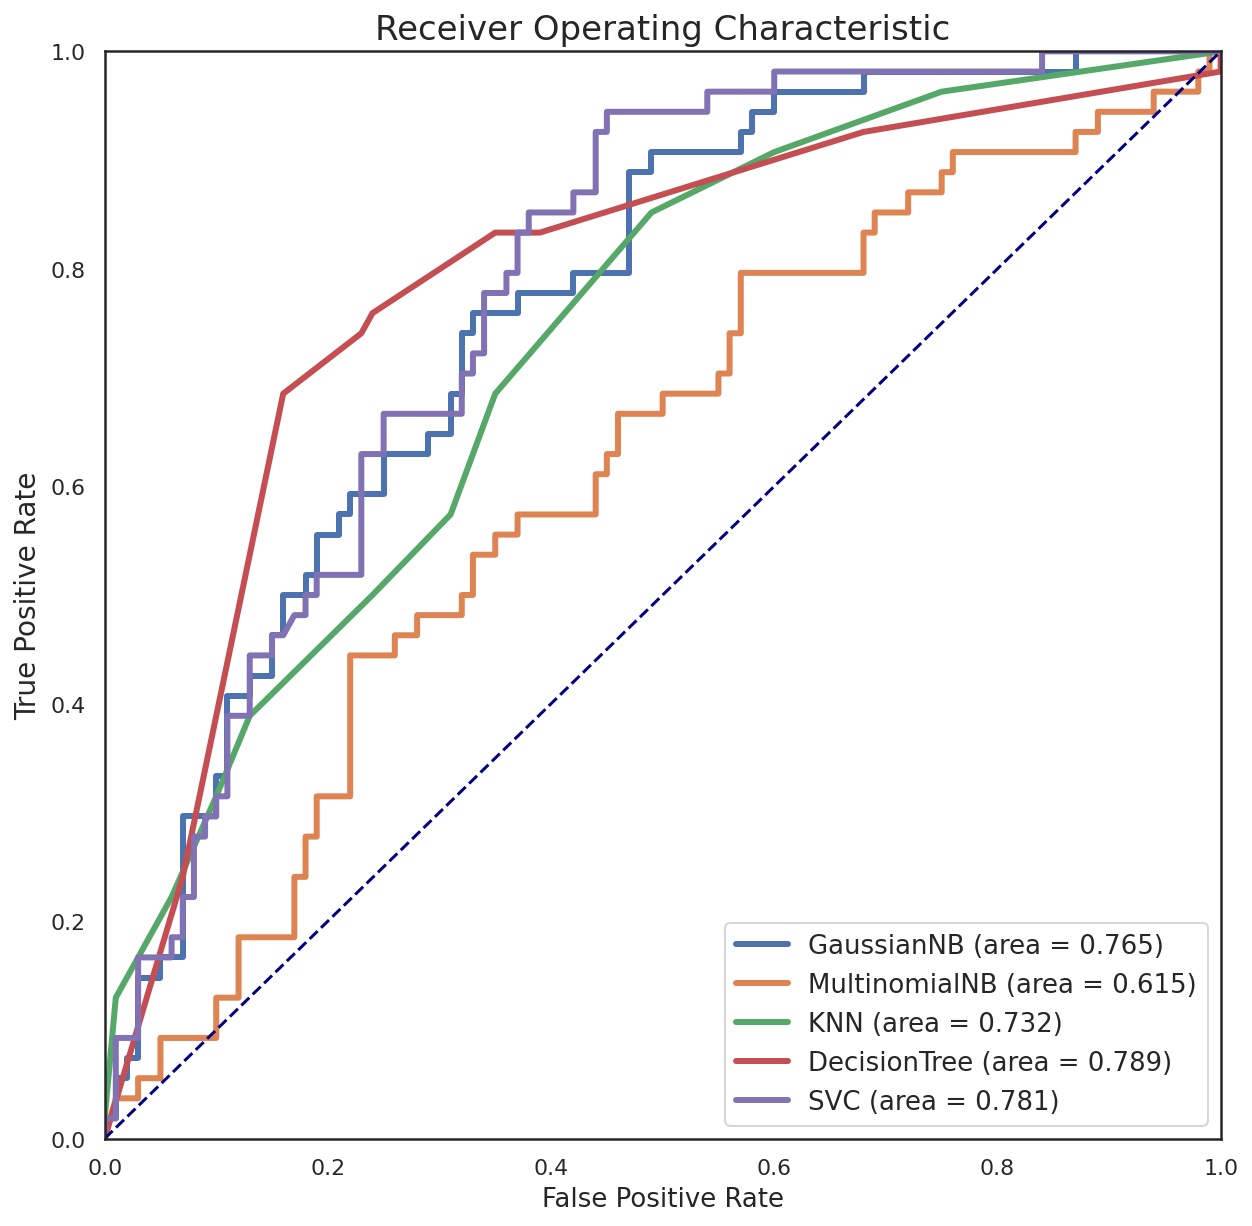

In [ ]:
# plot the ROC curves
plt.figure(figsize=(10,10))

model_name = [gnb,mnb,knn, decisiontree, svc]

for i in range(5):
    y_pred = model_name[i].predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    plt.plot(fpr, tpr, lw=3, label=df_models_tuned.model[i] + ' (area = %0.3f)' % auc(fpr, tpr))

plt.plot([0, 1], [0, 1], color='navy', lw=1.5, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate', fontsize=13)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic', fontsize=17)
plt.legend(loc='lower right', fontsize=13)
plt.show()

In [ ]:
# see how model confusion matrix varies with threshold
bestmodel = gnb

def make_confusion_matrix(model, threshold=0.5):
    # Predict class 1 if probability of being in class 1 is greater than threshold
    # (bestmodel.predict(X_test) is done automatically with a threshold of 0.5)
    y_pred = (bestmodel.predict_proba(X_test)[:, 1] >= threshold)
    conf = confusion_matrix(y_test, y_pred)
    plt.figure(figsize = [5,5])
    sns.heatmap(conf, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
           xticklabels=['no diabetes', 'diabetes'],
           yticklabels=['no diabetes', 'diabetes']);
    plt.xlabel('prediction')
    plt.ylabel('actual')

# Let's see how our confusion matrix changes with changes to the cutoff! 
from ipywidgets import interactive, FloatSlider
# bestmodel = LogisticRegression(C = optimal_c)
# bestmodel.fit(X_train, y_train)
interactive(lambda threshold: make_confusion_matrix(bestmodel, threshold), threshold=(0.0,1.0,0.01))

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.01), Output()), _dom_cla…

### The winning model is:

In [ ]:
# GaussianNB AUC: 0.8325
# Optimal threshold 0.207
# Precision: 0.5952,   Recall: 0.9091,   F1 Score: 0.7194
# GaussianNB confusion matrix: 
#  [[65 34]
#  [ 5 50]]

In [ ]:
# Difference between roc_auc_score(y_test, y_pred) and auc(fpr, tpr)
y_pred = gnb.predict(X_test)
model_roc_auc = roc_auc_score(y_test, y_pred)   # this is AUC score when threshold is default 0.5
print('gnb', 'roc_auc_score: {:.4f}'.format(model_roc_auc)) 

y_pred = gnb.predict_proba(X_test)[:,1]>0.5    # predict_proba to adjust threshold to 0.5, same results
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
model_auc = auc(fpr, tpr)
print('gnb', 'AUC: {:.4f}'.format(model_auc))

y_pred = gnb.predict_proba(X_test)[:,1]   # use this for optimal threshold after tuning
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
model_auc = auc(fpr, tpr)
print('gnb', 'AUC: {:.4f}'.format(model_auc))

gnb roc_auc_score: 0.6848
gnb AUC: 0.6848
gnb AUC: 0.7646
